In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import ast
import re
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

In [366]:
data = pd.read_csv('listings.csv')

# convert price from string to float
data['price'] = data['price'].str.replace(r'[\$,]', '', regex=True).astype(float)

# drop rows where price = NaN
data.dropna(subset=['price'], inplace=True)

# convert price to log_price
data["price"] = np.log(data["price"])

list(data.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

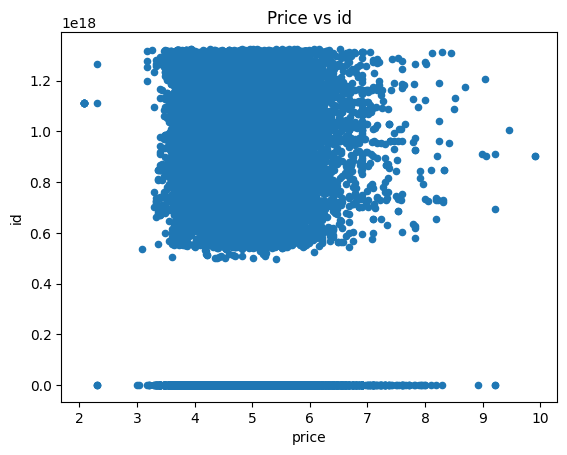

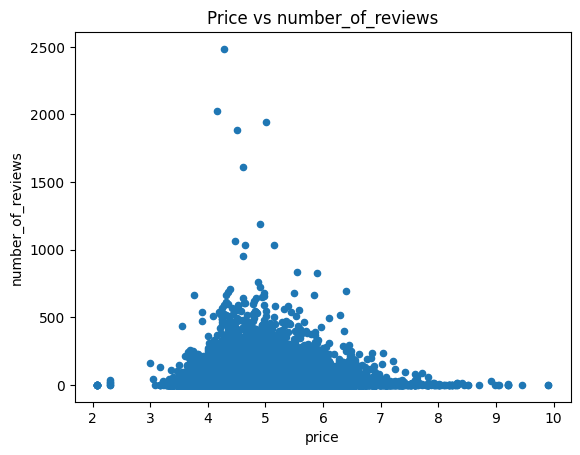

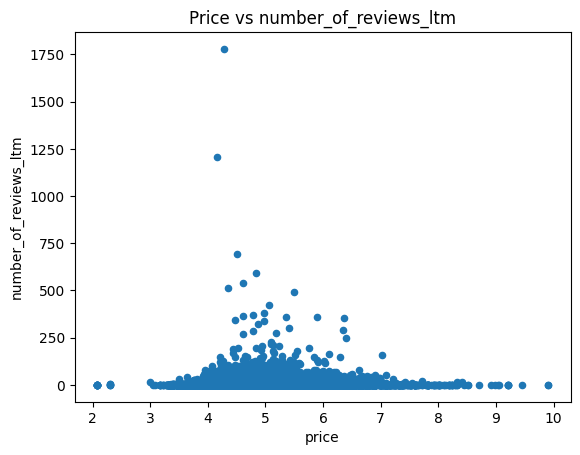

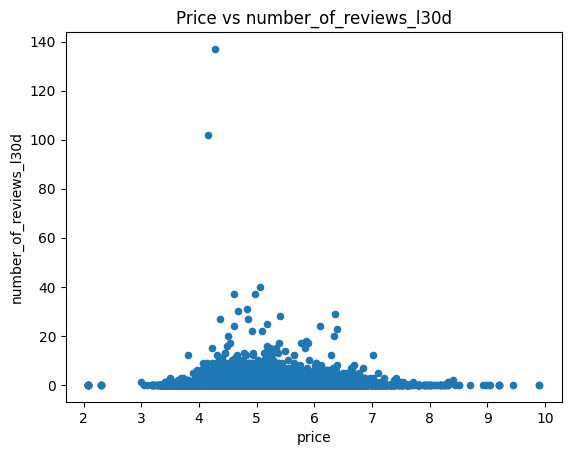

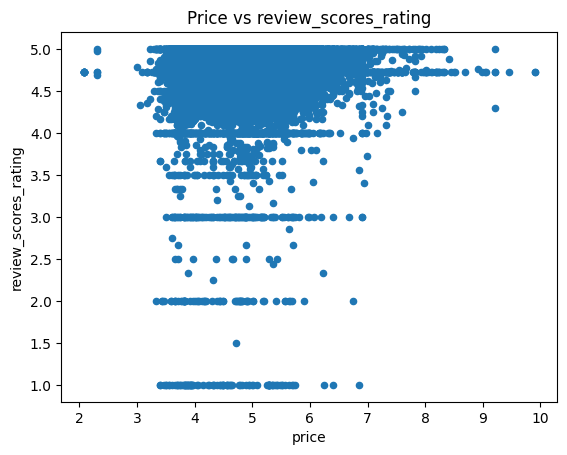

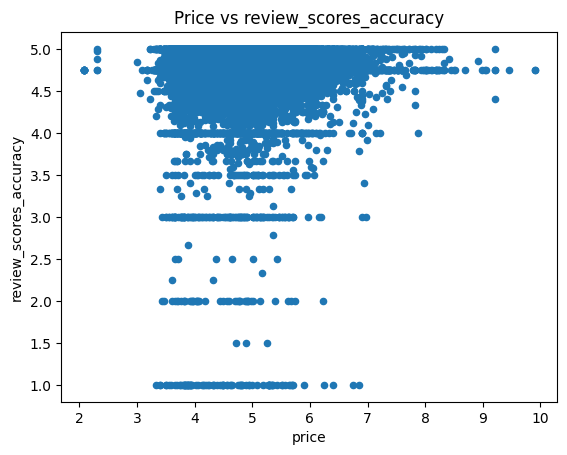

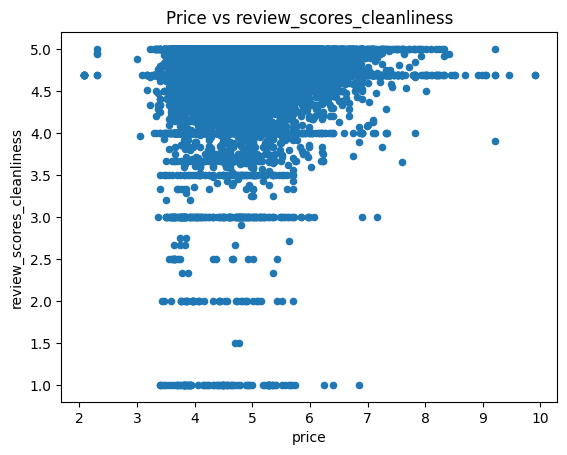

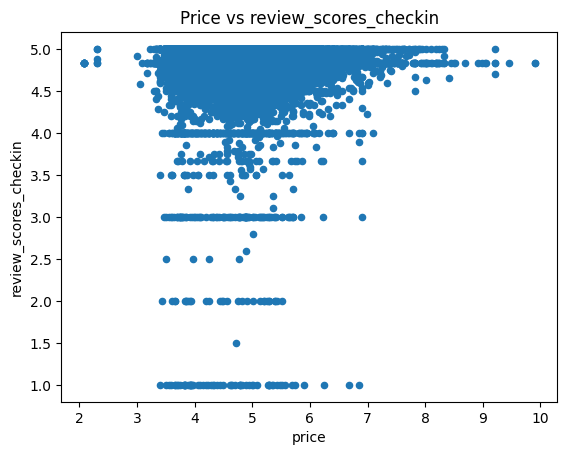

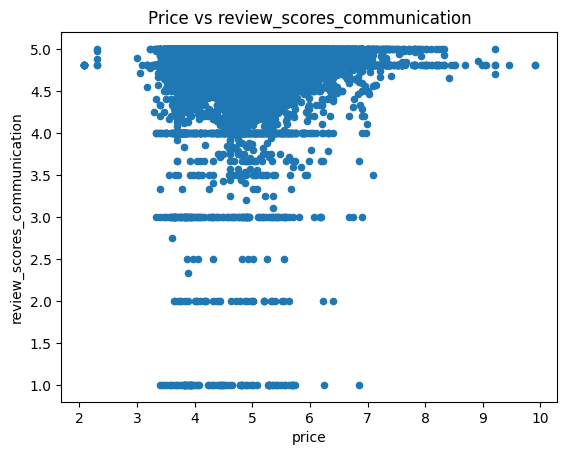

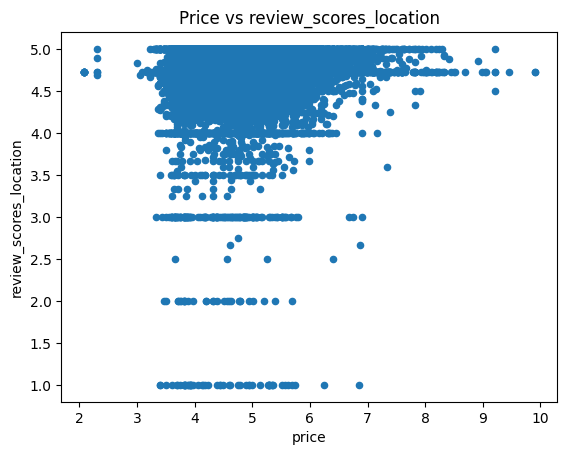

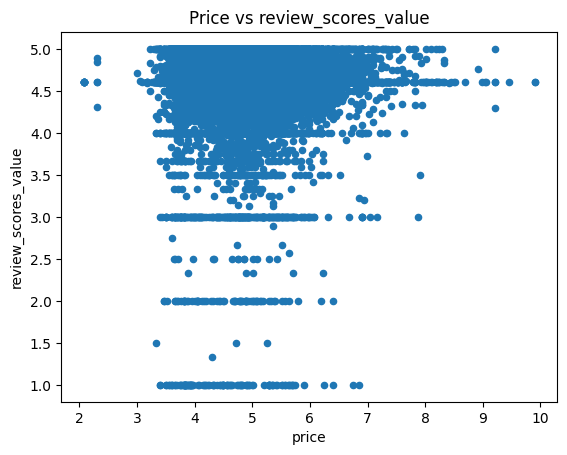

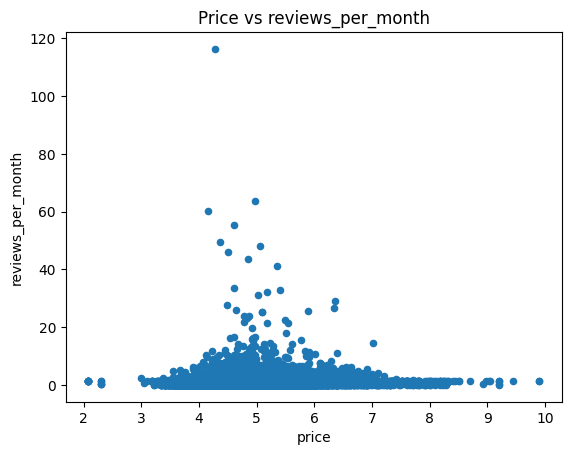

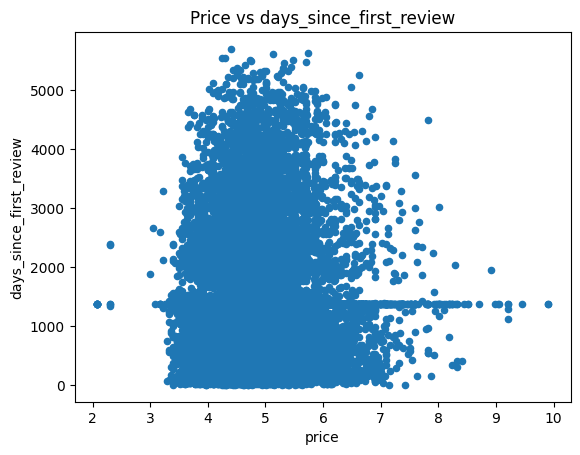

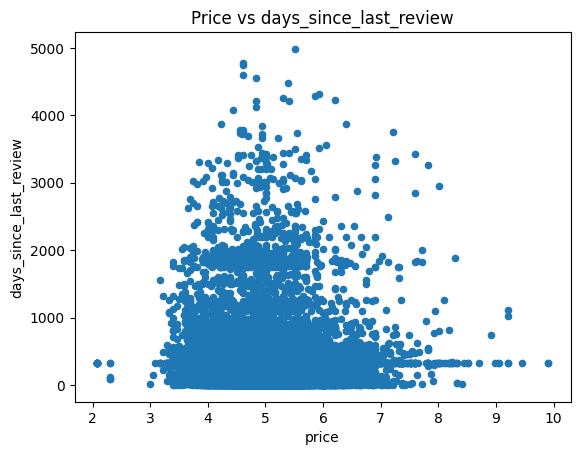

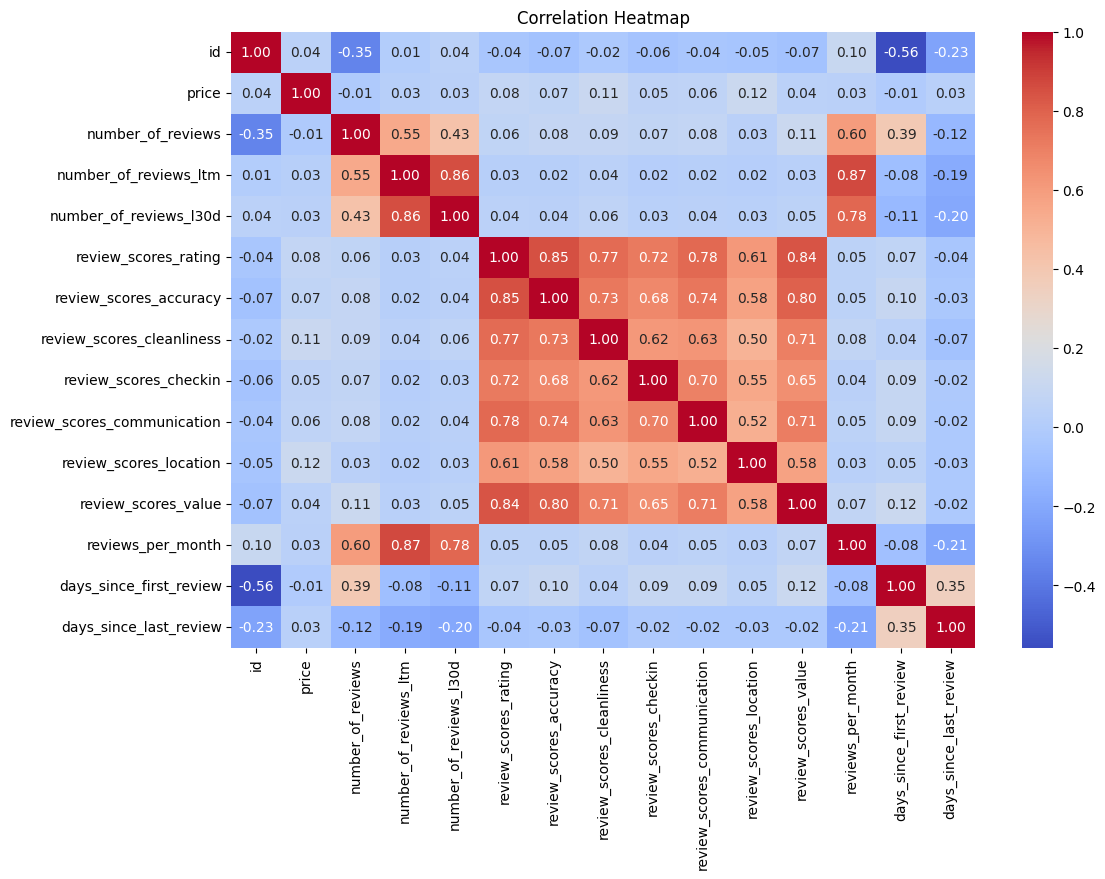

In [367]:
# reviews bucket
reviews_bucket = data.filter(regex='review|^price$|^id[s]?$').copy()


# convert first_review and last_review to days_since_first_review and days_since_last_review respectively
reviews_bucket['first_review'] = pd.to_datetime(data['first_review'])
reviews_bucket['last_review'] = pd.to_datetime(data['last_review'])
max_date = reviews_bucket['last_review'].max()
reviews_bucket['days_since_first_review'] = (max_date - reviews_bucket['first_review']).dt.days
reviews_bucket['days_since_last_review']  = (max_date - reviews_bucket['last_review']).dt.days
reviews_bucket.drop(columns=['first_review', 'last_review'], inplace=True)

# fill null values with mean
reviews_bucket.fillna(reviews_bucket.mean(), inplace=True)


cols = [col for col in reviews_bucket.select_dtypes(include='number').columns if col != 'price']
# Loop over each column and plot scatterplot vs. price
for col in cols:
    reviews_bucket.plot.scatter(x='price', y=col, title=f"Price vs {col}")
    plt.show()


# deal with outliers
# row_ids_1 = reviews_bucket.loc[reviews_bucket['number_of_reviews_l30d'] > 60, 'id']   -> 593322347340602809, 858697692672545141
# row_ids_2 = reviews_bucket.loc[reviews_bucket['reviews_per_month'] > 100, 'id']       -> 858697692672545141
# row_ids_3 = reviews_bucket.loc[reviews_bucket['number_of_reviews'] > 1800, 'id']      -> 37122502, 51619634, 593322347340602809, 858697692672545141
# row_ids_4 = reviews_bucket.loc[reviews_bucket['number_of_reviews_ltm'] > 1000, 'id']  -> 593322347340602809, 858697692672545141
ids_to_drop = [593322347340602809, 85869769267254514]
reviews_bucket = reviews_bucket.loc[~reviews_bucket['id'].isin(ids_to_drop)]


# correlation
corr_matrix = reviews_bucket.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# conclusion: only review_scores_cleanliness and review_scores_location seem to matter the most, drop everything else
reviews_bucket = reviews_bucket[['id', 'price', 'review_scores_cleanliness', 'review_scores_location']]

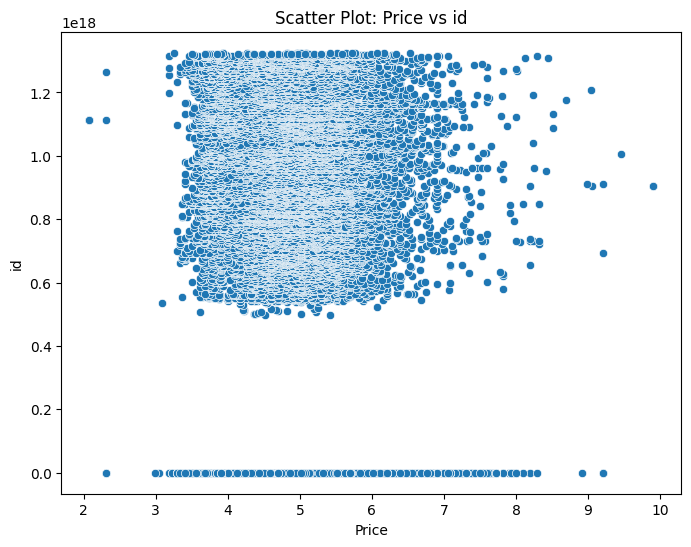

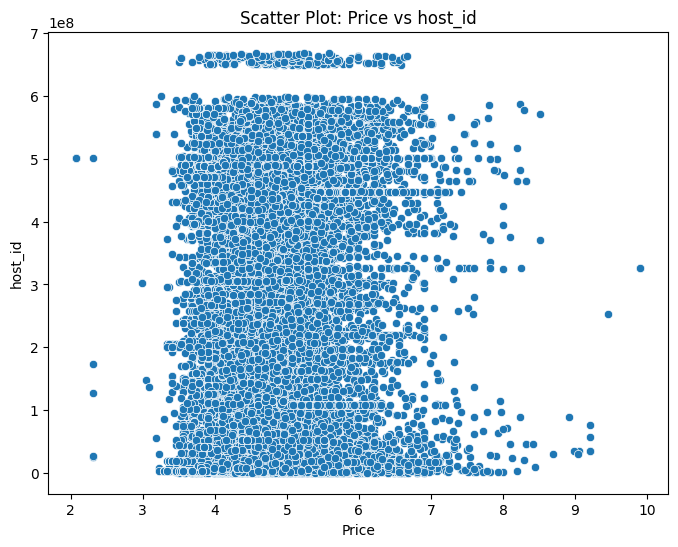

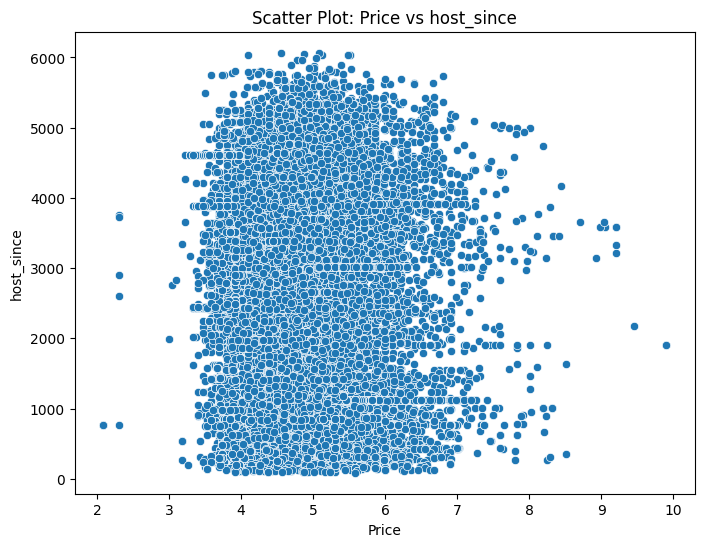

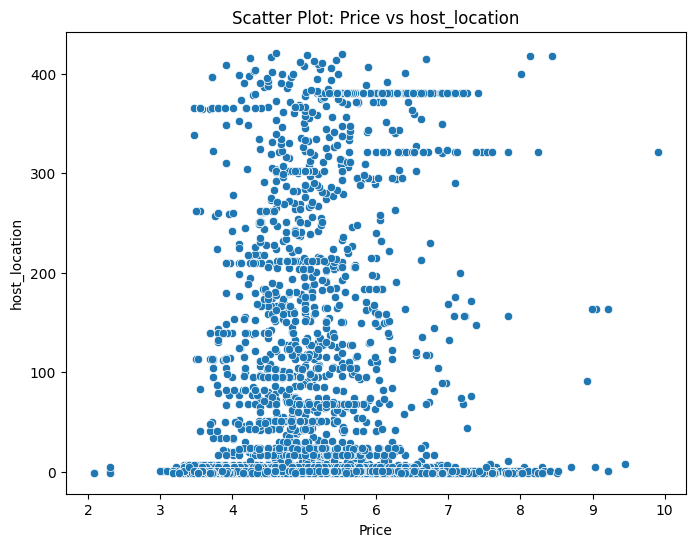

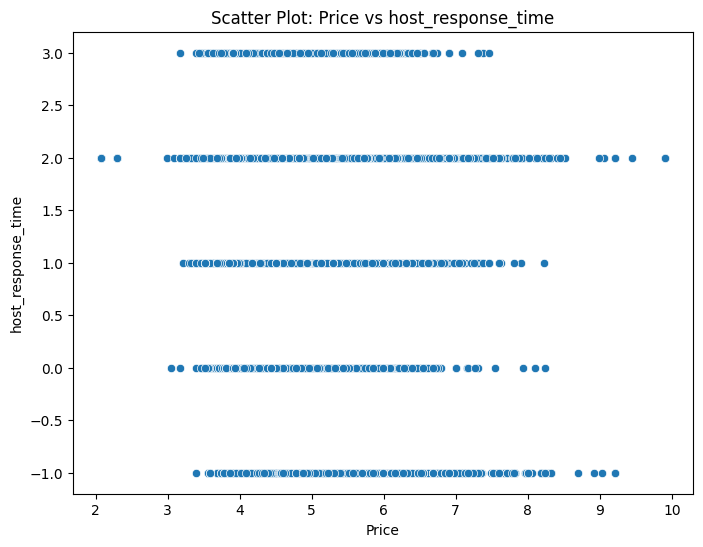

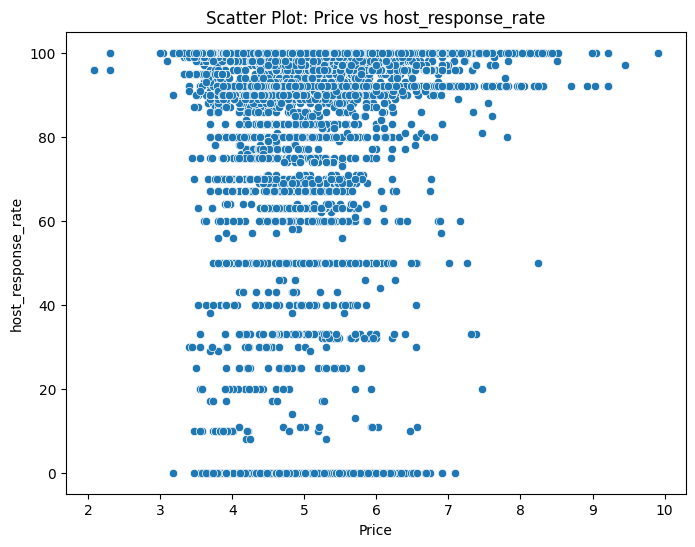

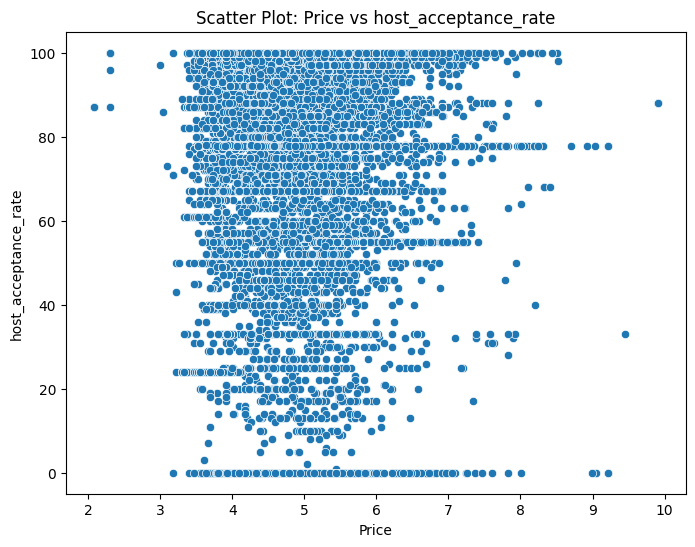

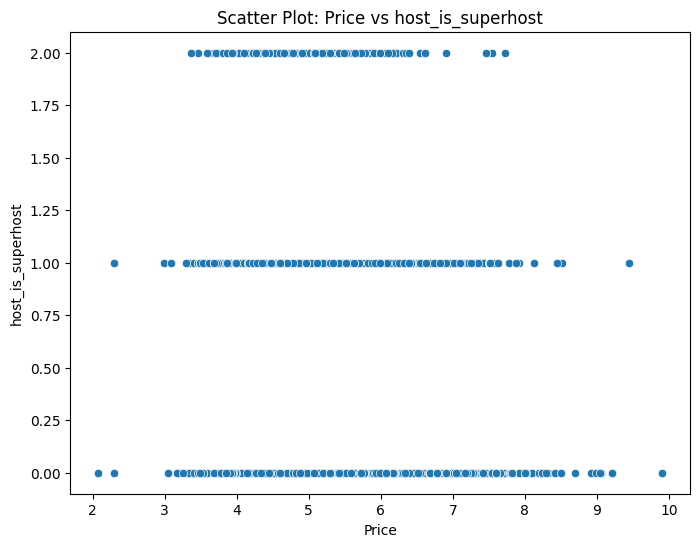

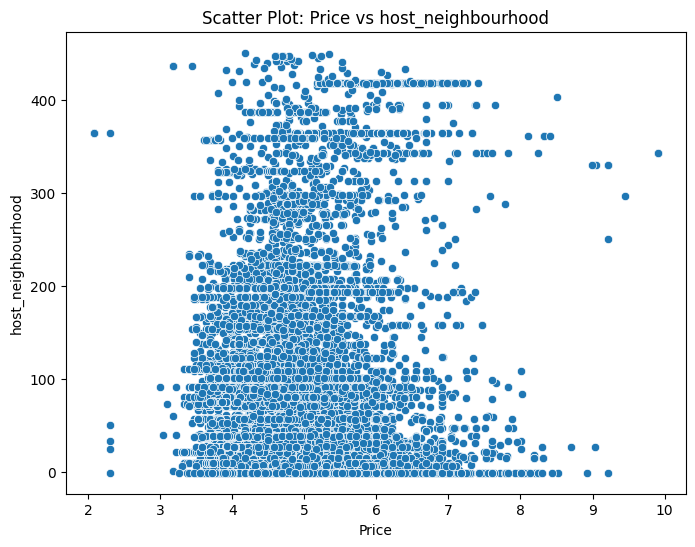

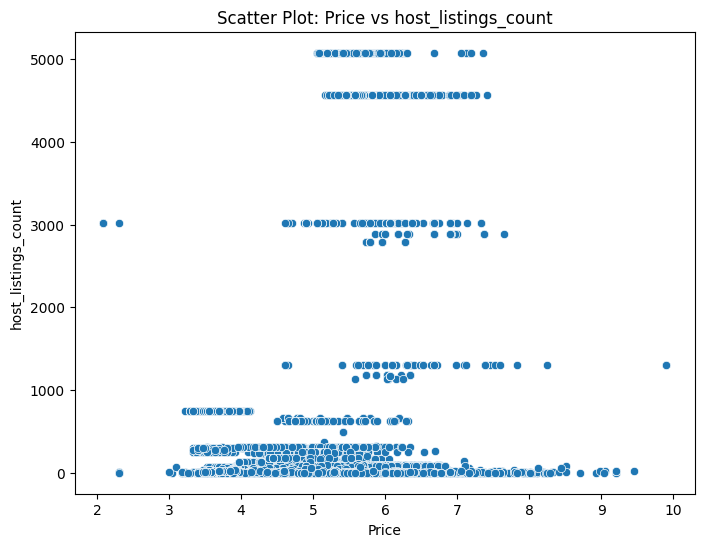

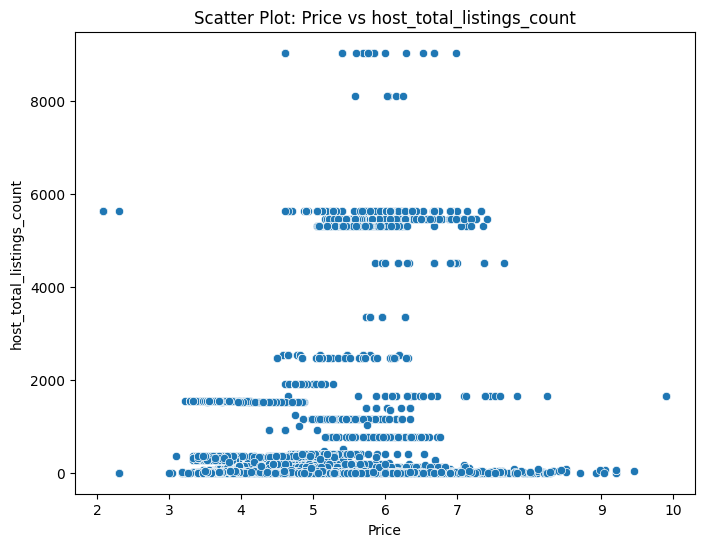

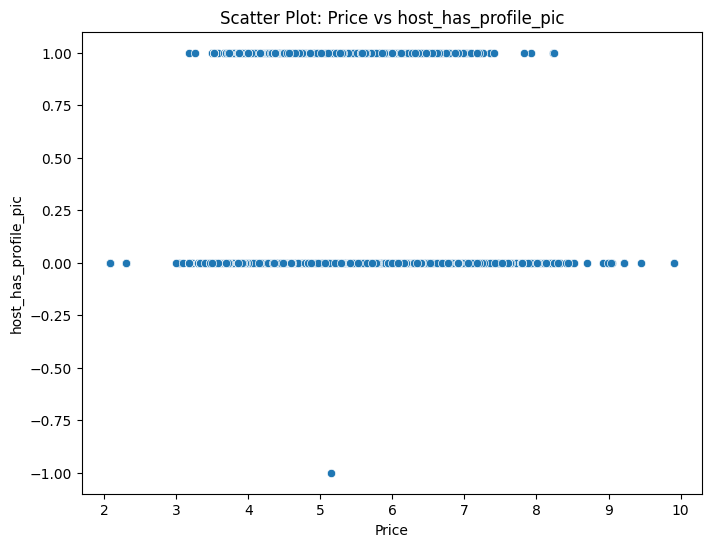

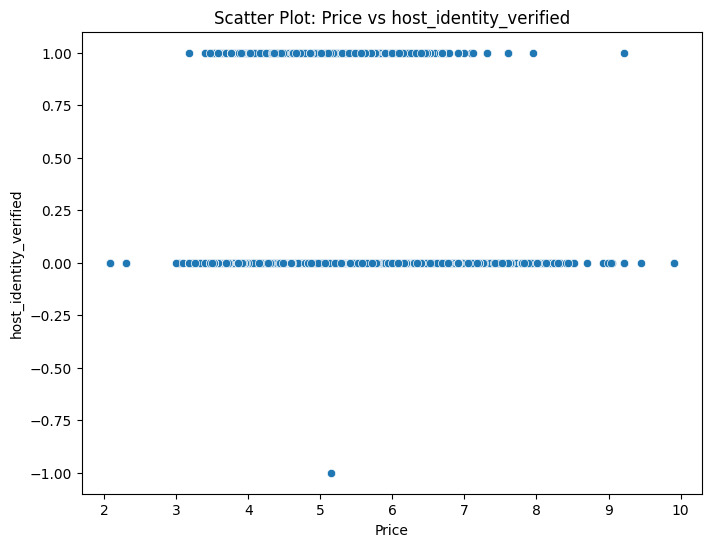

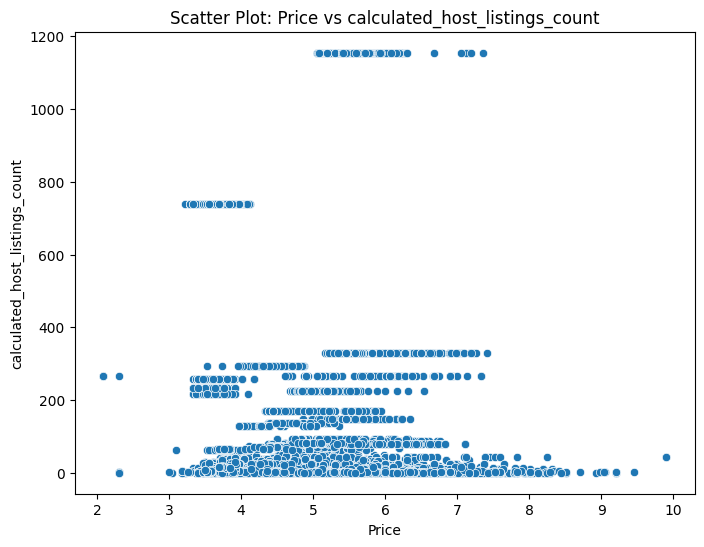

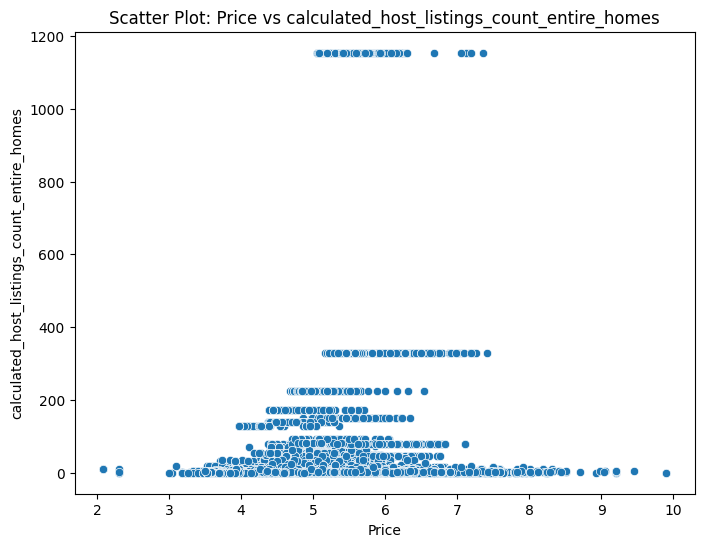

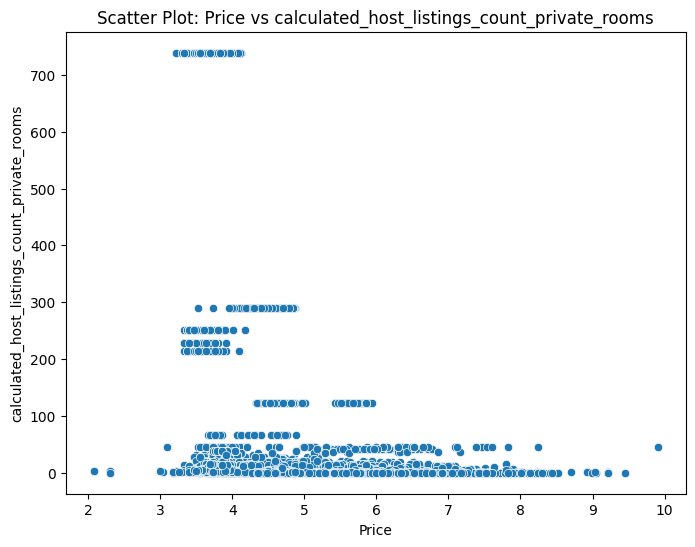

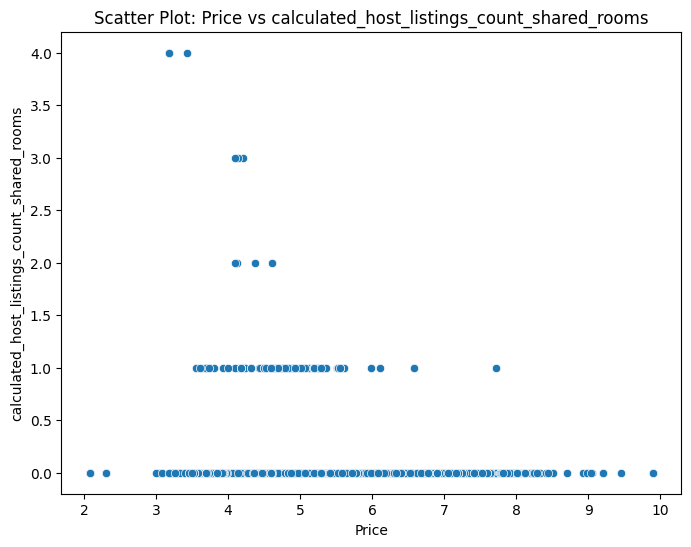

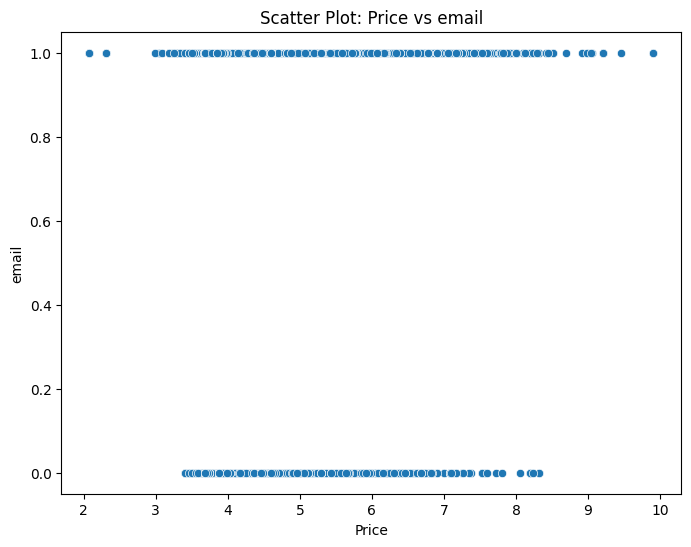

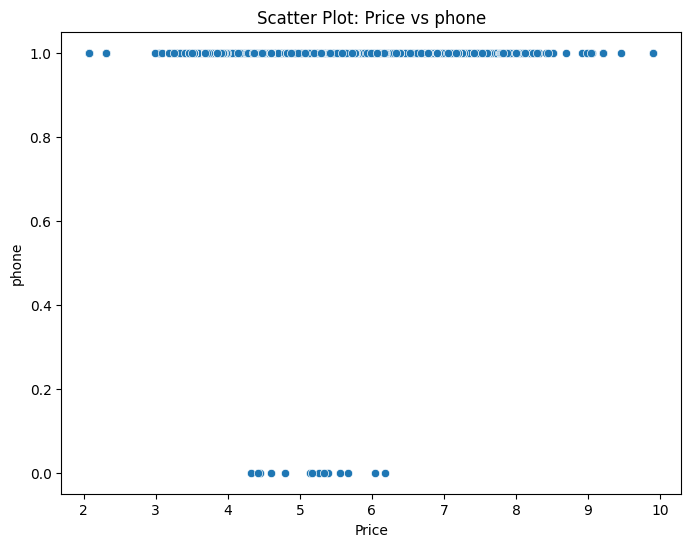

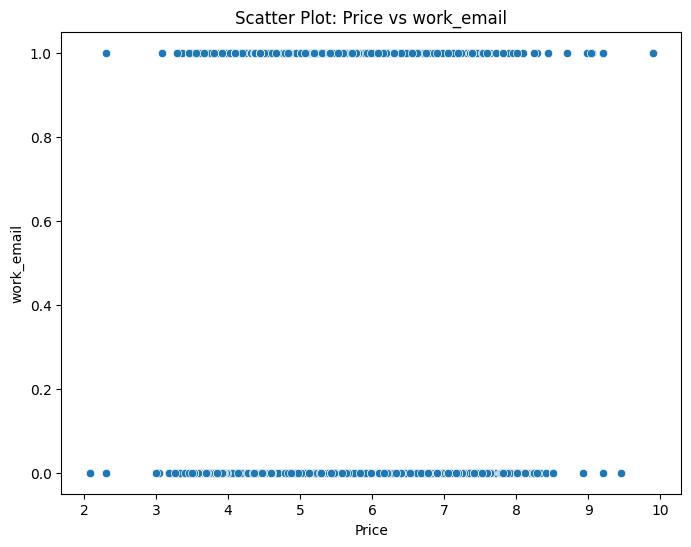

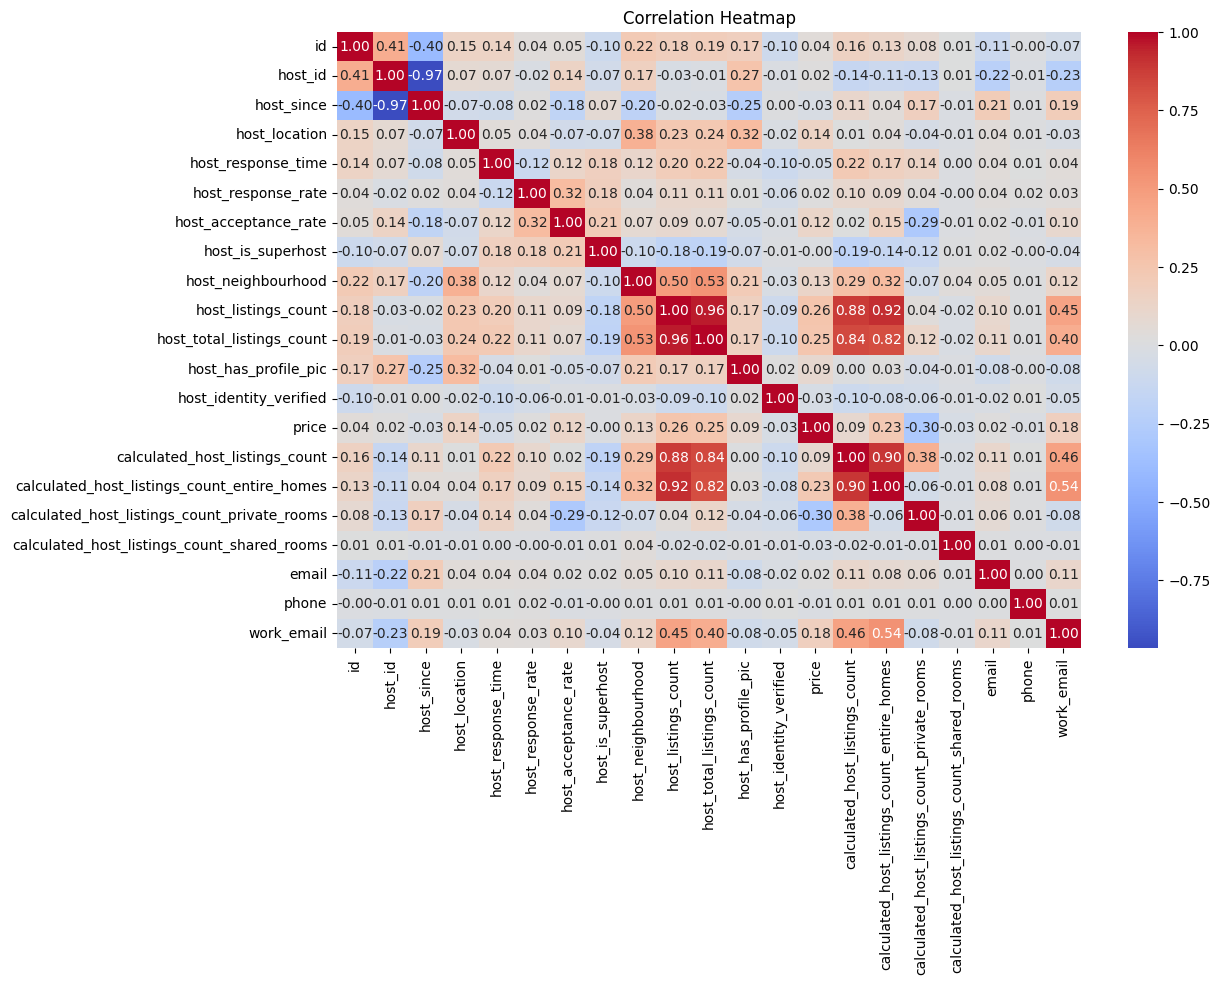

In [368]:
# host bucket
host_bucket = [col for col in data.columns 
                    if col.startswith('host_') or col.startswith('calculated_host_') or col == 'price' or col == 'id']

host_bucket = data[host_bucket]
# host_bucket.info()
host_bucket.head()


# drop url, host_name, host_about, host_thumbnail_url, host_picture_url
host_bucket = host_bucket.drop(columns=['host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url'])


# make host_response_time categorical
host_bucket['host_response_time'], uniques = pd.factorize(host_bucket['host_response_time'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_response_time:", mapping)


# make host_location categorical
host_bucket['host_location'], uniques = pd.factorize(host_bucket['host_location'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_location:", mapping)
host_bucket.head()


# make host_response_rate numerical
host_bucket['host_response_rate'] = host_bucket['host_response_rate'].str.rstrip('%').astype(float)


# make host_acceptance_rate numerical
host_bucket['host_acceptance_rate'] = host_bucket['host_acceptance_rate'].str.rstrip('%').astype(float)


# make host_is_superhost numerical
host_bucket['host_is_superhost'], uniques = pd.factorize(host_bucket['host_is_superhost'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_is_superhost:", mapping)


# host_verifications: check which verification affects price the most
def parse_verifications(x):
    if pd.isna(x) or x == '[]':
        return []
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

host_bucket['verifications'] = host_bucket['host_verifications'].apply(parse_verifications)
host_bucket['email'] = host_bucket['verifications'].apply(lambda x: 1 if 'email' in x else 0)
host_bucket['phone'] = host_bucket['verifications'].apply(lambda x: 1 if 'phone' in x else 0)
host_bucket['work_email'] = host_bucket['verifications'].apply(lambda x: 1 if 'work_email' in x else 0)
host_bucket = host_bucket.drop(columns=['verifications', 'host_verifications'])



# make host_is_superhost numerical
host_bucket['host_is_superhost'], uniques = pd.factorize(host_bucket['host_is_superhost'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_is_superhost:", mapping)


# make host_has_profile_pic numerical
host_bucket['host_has_profile_pic'], uniques = pd.factorize(host_bucket['host_has_profile_pic'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_has_profile_pic:", mapping)


# make host_identity_verified numerical
host_bucket['host_identity_verified'], uniques = pd.factorize(host_bucket['host_identity_verified'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_identity_verified:", mapping)


# make host_neighbourhood numerical
host_bucket['host_neighbourhood'], uniques = pd.factorize(host_bucket['host_neighbourhood'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of host_neighbourhood:", mapping)


# handle host_since: make it (today's date - host_since)
host_bucket['host_since'] = pd.to_datetime(host_bucket['host_since'])
today = pd.Timestamp.today()
host_bucket['host_since'] = (today - host_bucket['host_since']).dt.days


# fill na column with mean
host_bucket.fillna(host_bucket.mean(), inplace=True)


# scatterplot vs price
for col in host_bucket.columns:
    if col != 'price':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='price', y=col, data=host_bucket)
        plt.title(f'Scatter Plot: Price vs {col}')
        plt.xlabel('Price')
        plt.ylabel(col)
        plt.show()

# handle outlieres
# row_ids_1 = host_bucket.loc[host_bucket['host_identity_verified'] == -1, 'id']    -> 53363486
# row_ids_2 = host_bucket.loc[host_bucket['host_has_profile_pic'] == -1, 'id']      -> 53363486
ids_to_remove = [53363486]
host_bucket = host_bucket.loc[~host_bucket['id'].isin(ids_to_drop)] 


# correlation
corr_matrix = host_bucket.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# conclusion
host_bucket = host_bucket[['id', 'host_location', 'host_acceptance_rate', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'work_email']]

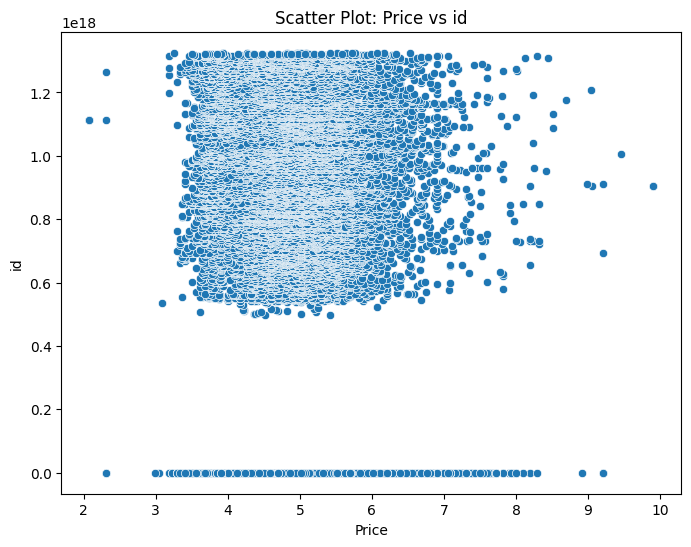

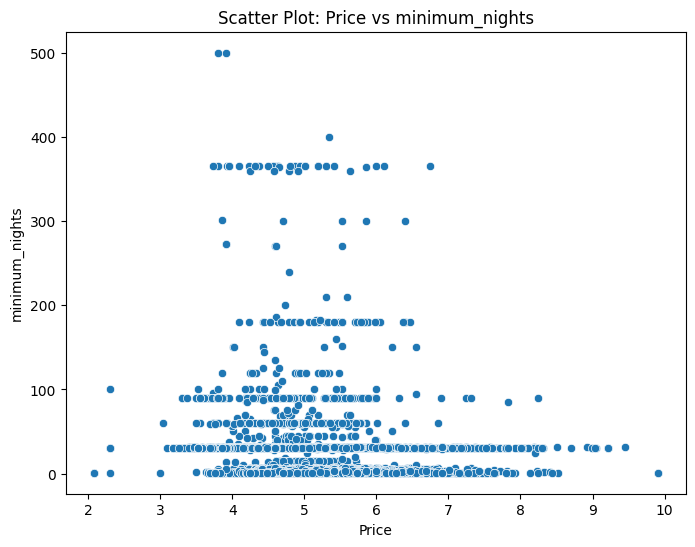

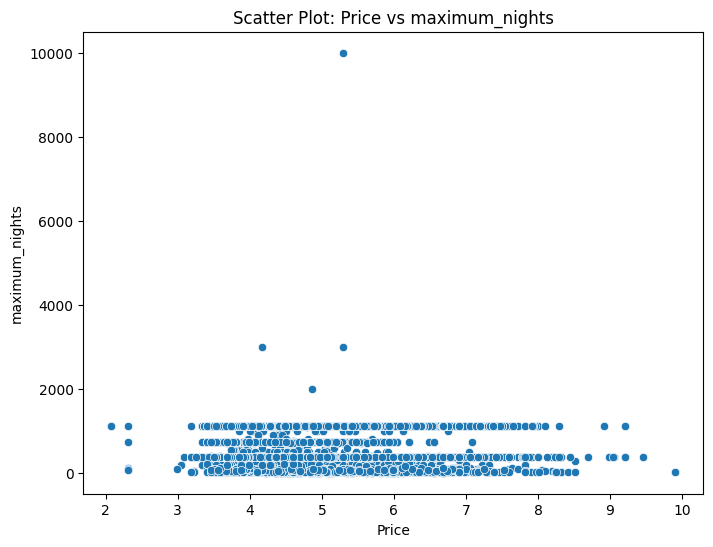

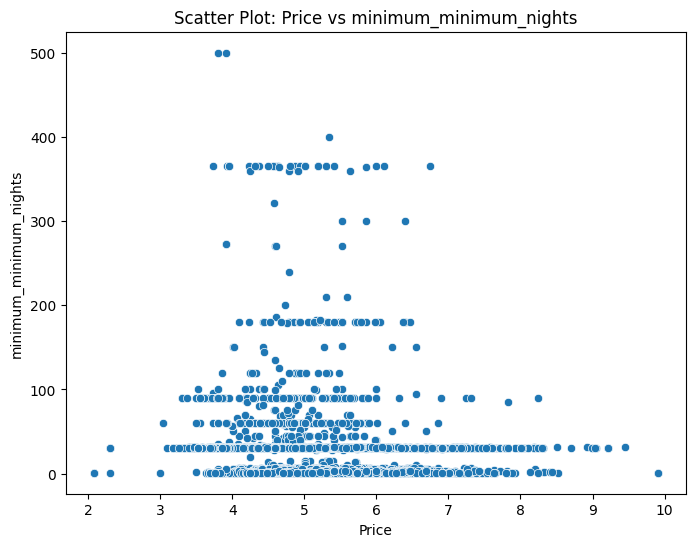

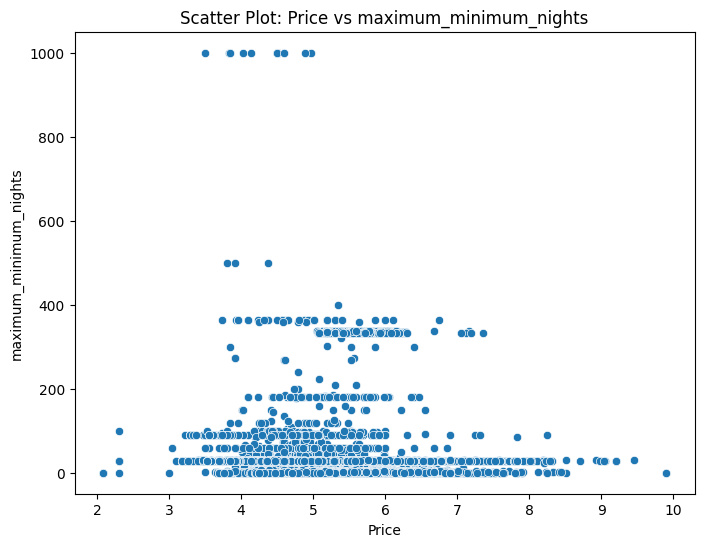

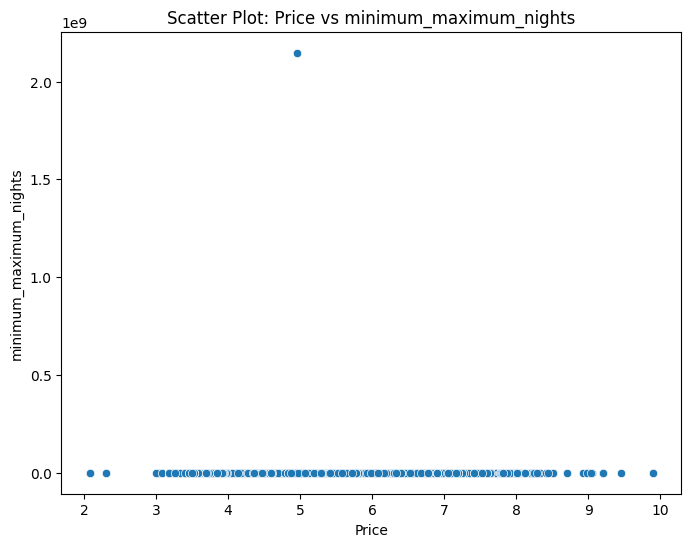

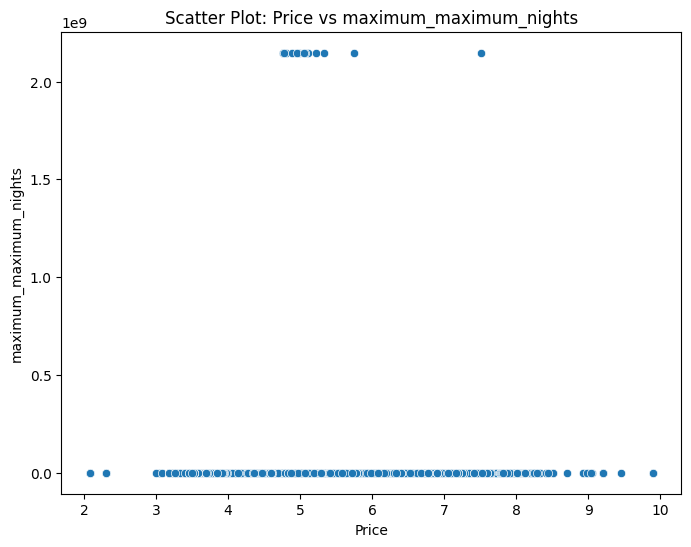

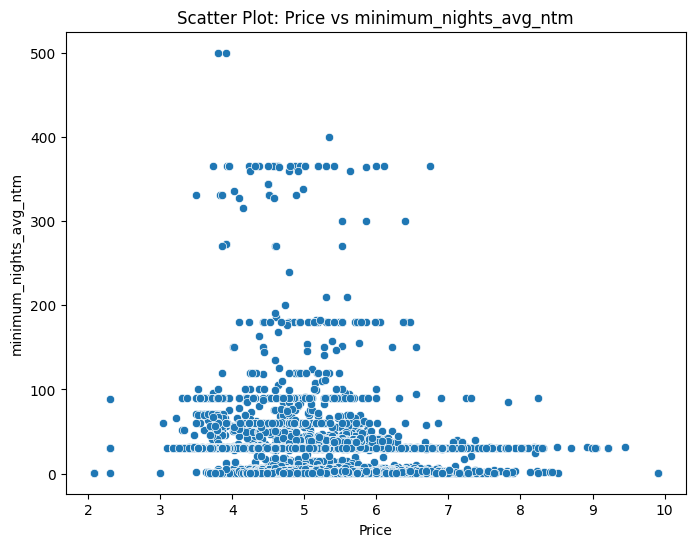

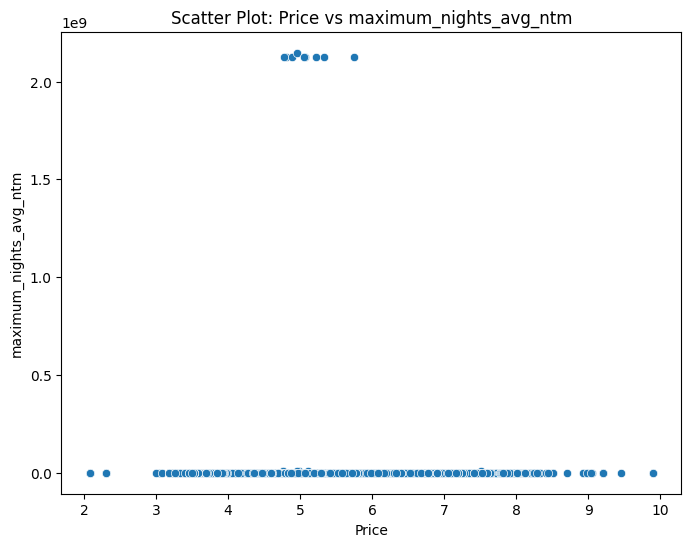

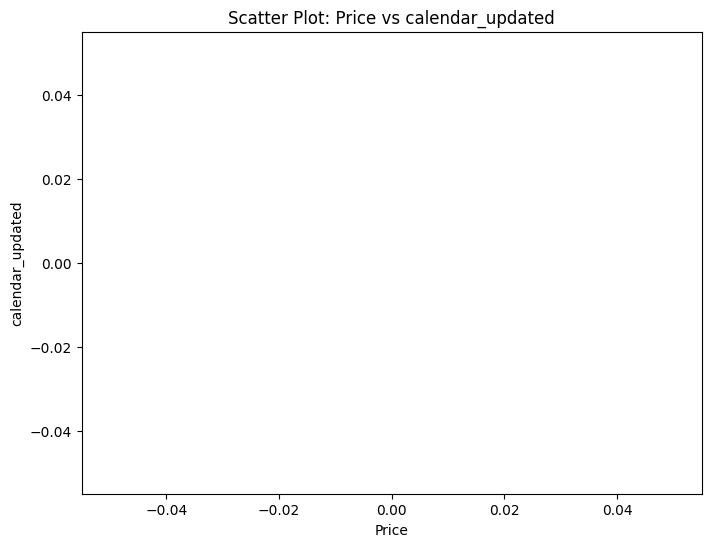

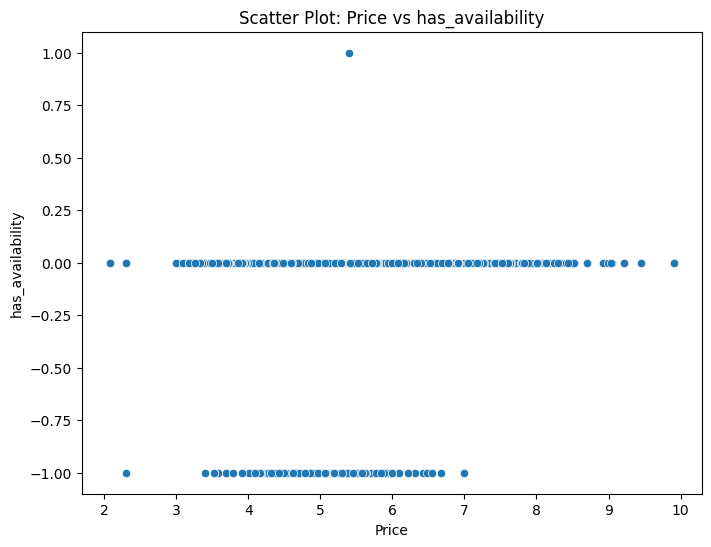

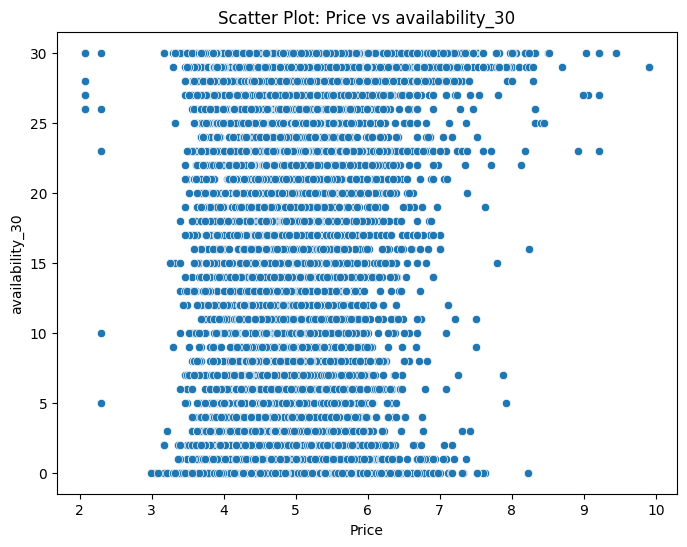

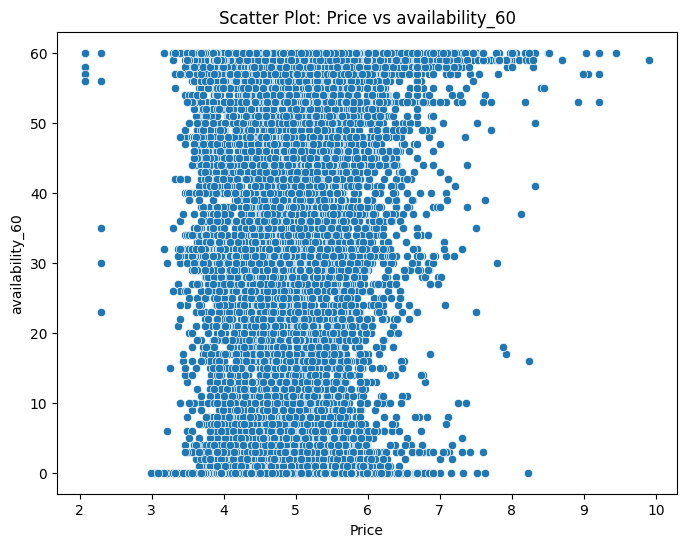

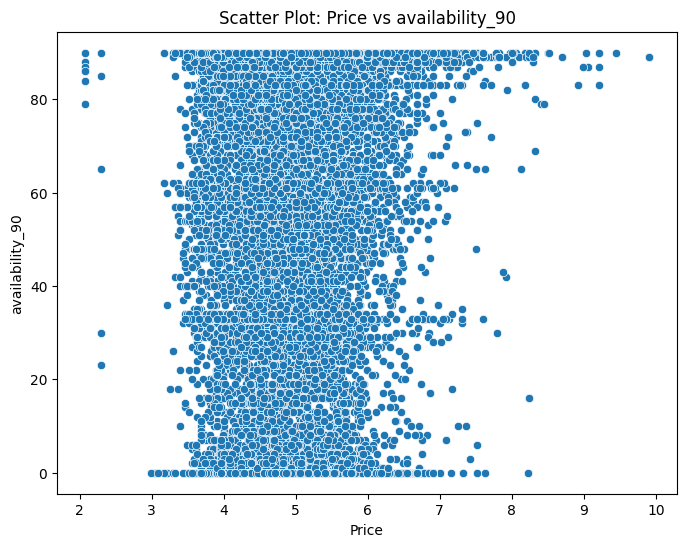

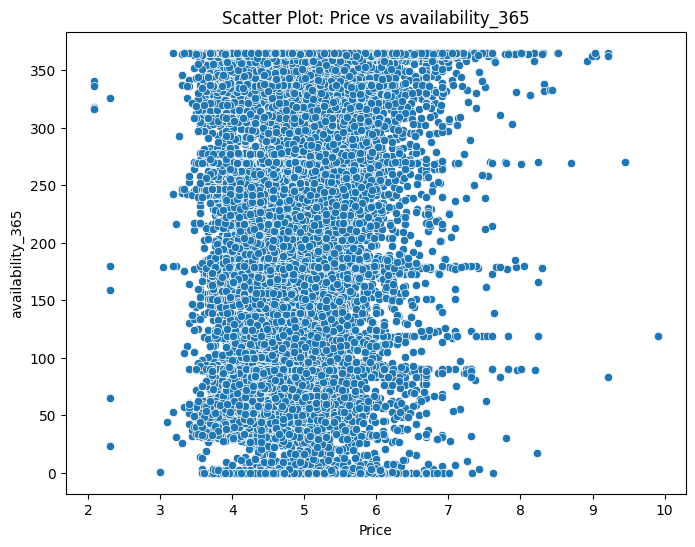

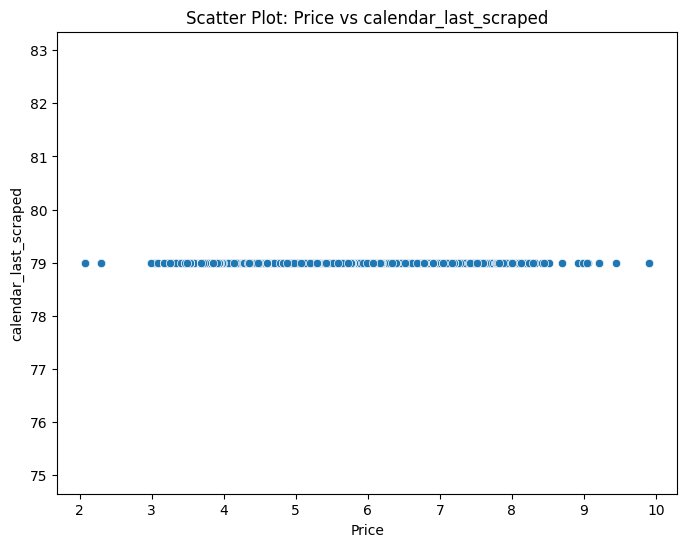

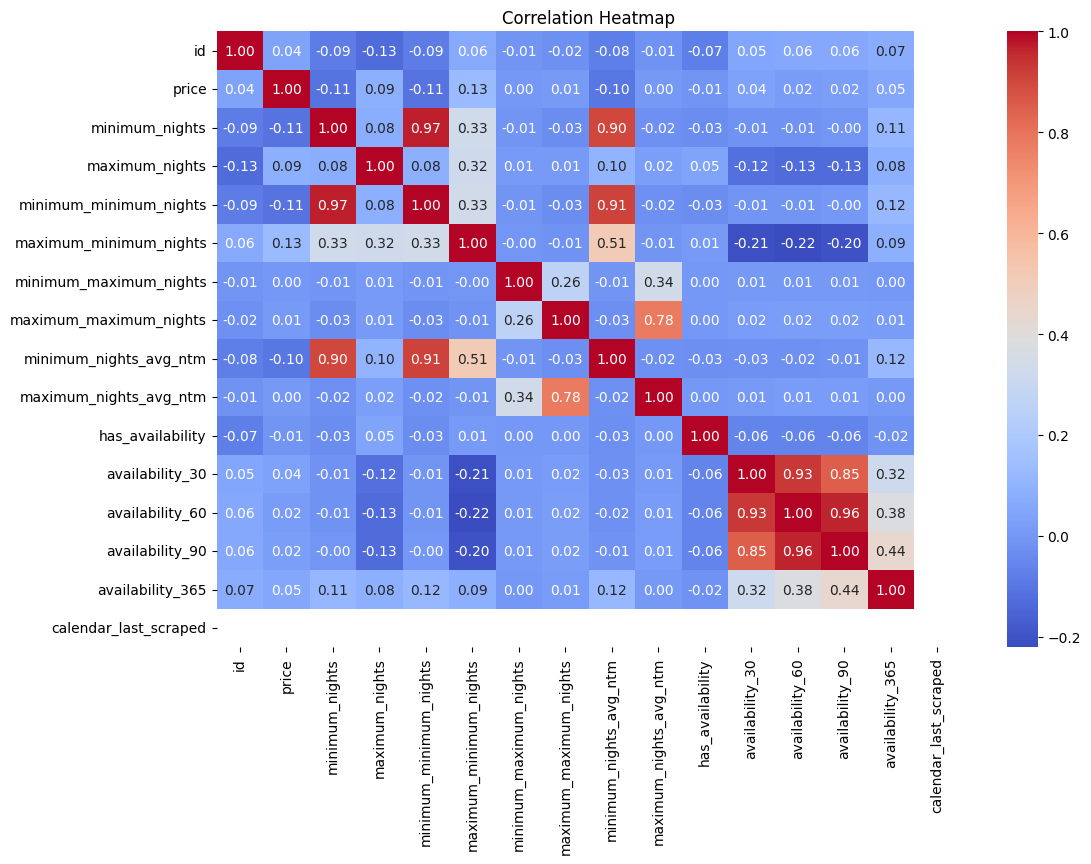

In [369]:
# availability bucket
availability_bucket = [col for col in data.columns 
                       if col in ['id', 'price', 'minimum_nights', 'maximum_nights', 
                                  'minimum_minimum_nights', 'maximum_minimum_nights', 
                                  'minimum_maximum_nights', 'maximum_maximum_nights', 
                                  'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                                  'calendar_updated', 'has_availability', 
                                  'availability_30', 'availability_60', 
                                  'availability_90', 'availability_365', 
                                  'calendar_last_scraped']]

availability_bucket = data[availability_bucket].copy()


# convert calendar_last_scraped to float
availability_bucket['calendar_last_scraped'] = pd.to_datetime(availability_bucket['calendar_last_scraped'])
today = pd.Timestamp.today()
availability_bucket['calendar_last_scraped'] = (today - availability_bucket['calendar_last_scraped']).dt.days


# convert has_availability to numerical
availability_bucket['has_availability'], uniques = pd.factorize(availability_bucket['has_availability'])
mapping = dict(zip(uniques, range(0, len(uniques))))
# print("Mapping of has_availability:", mapping)


# scatterplot vs price
for col in availability_bucket.columns:
    if col != 'price':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='price', y=col, data=availability_bucket)
        plt.title(f'Scatter Plot: Price vs {col}')
        plt.xlabel('Price')
        plt.ylabel(col)
        plt.show()


# drop calendar_updated
availability_bucket = availability_bucket.drop(columns=['calendar_updated'])


# correlation
corr_matrix = availability_bucket.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

availability_bucket = availability_bucket[['id']]

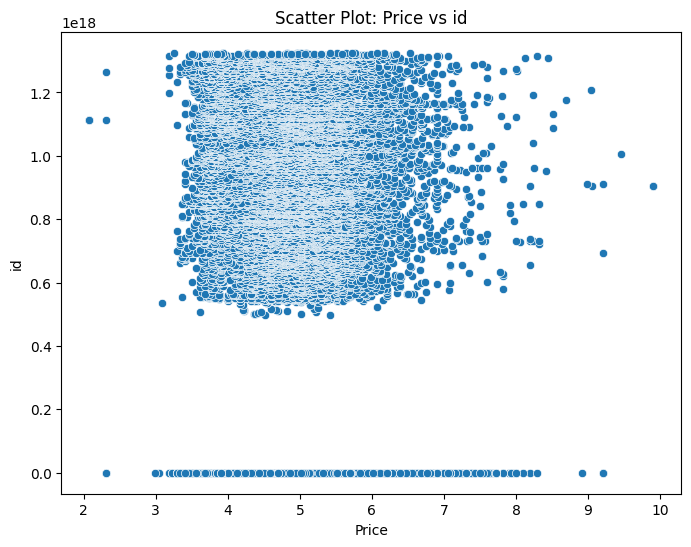

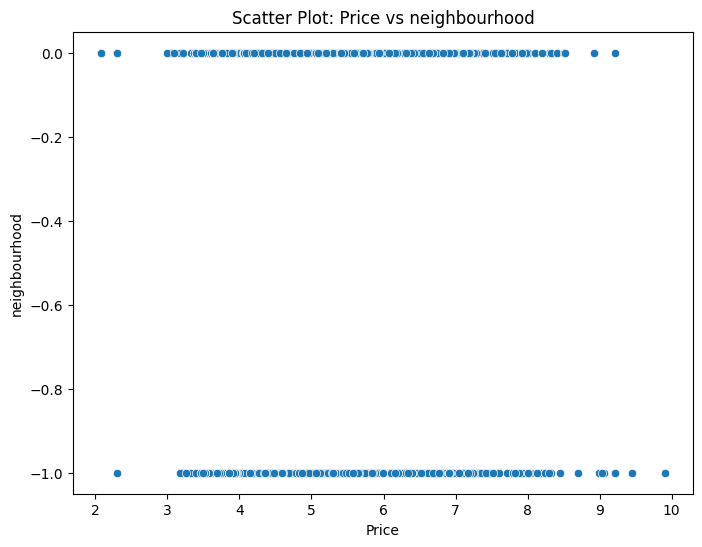

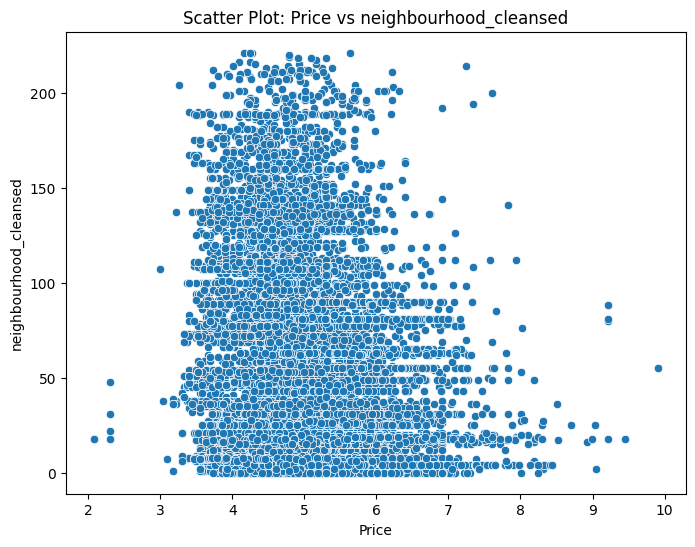

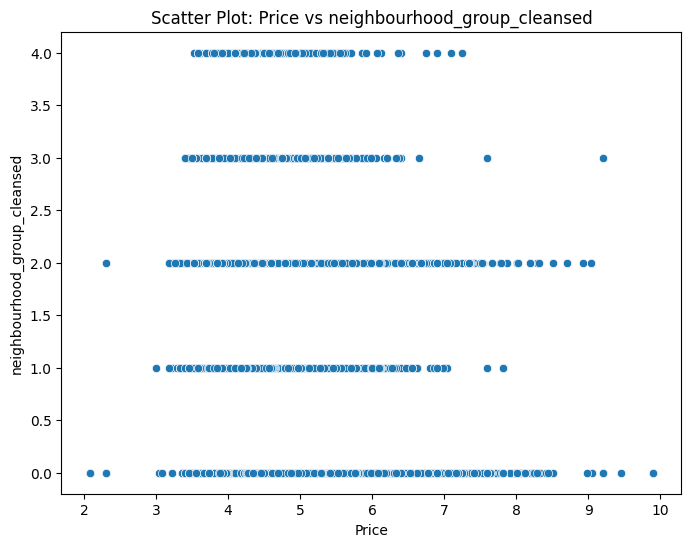

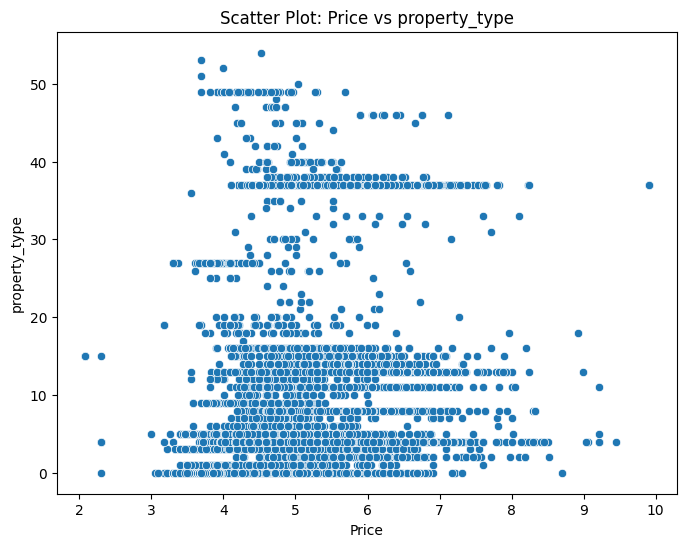

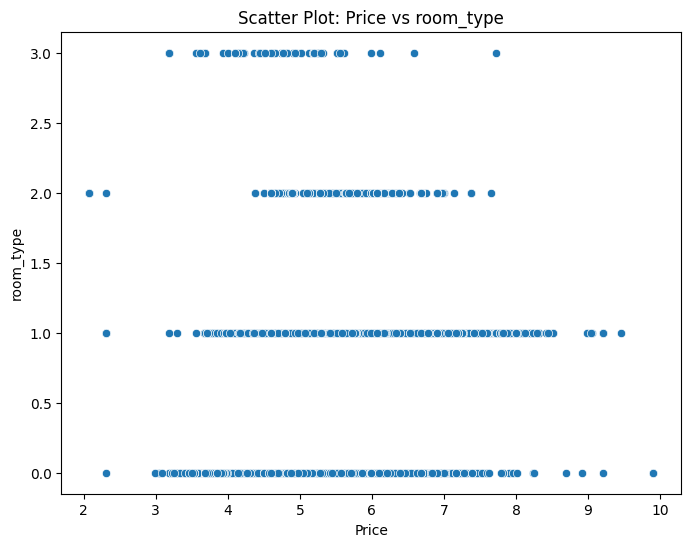

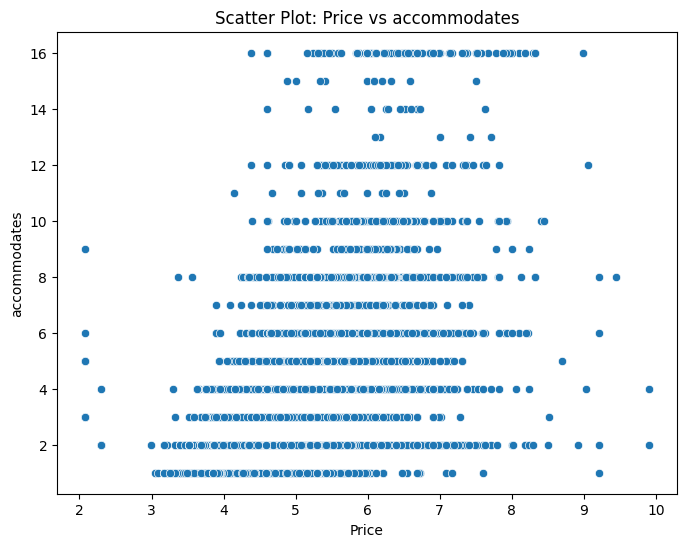

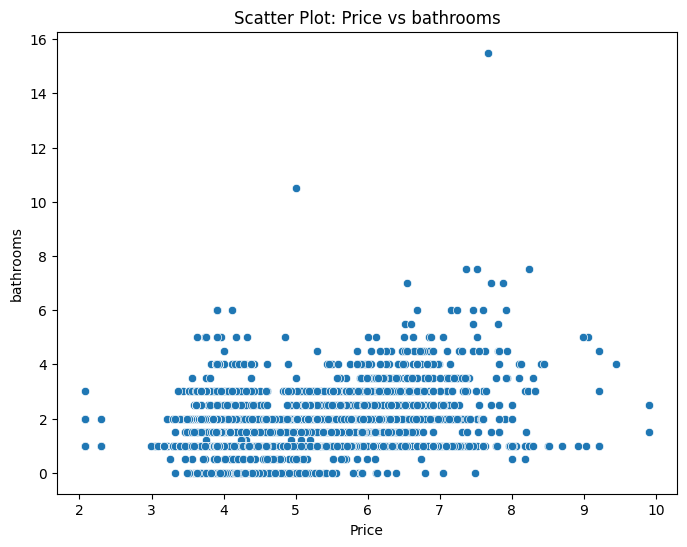

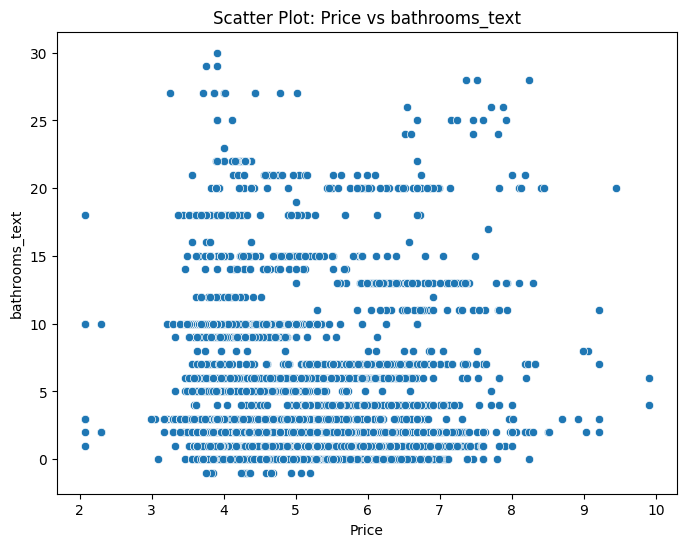

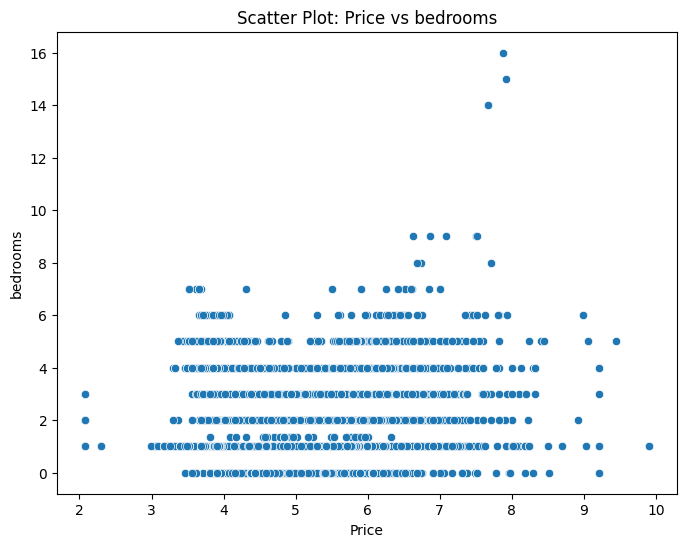

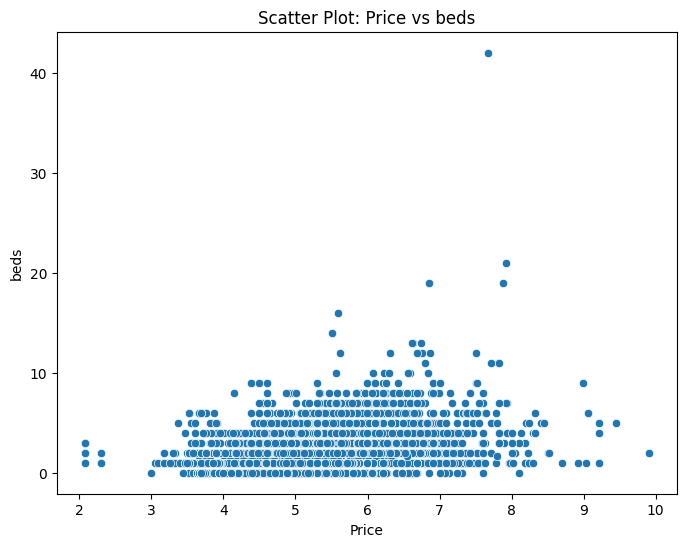

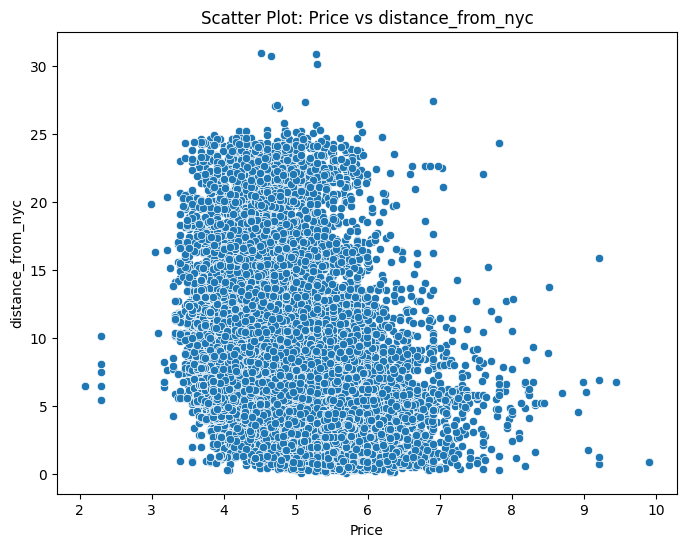

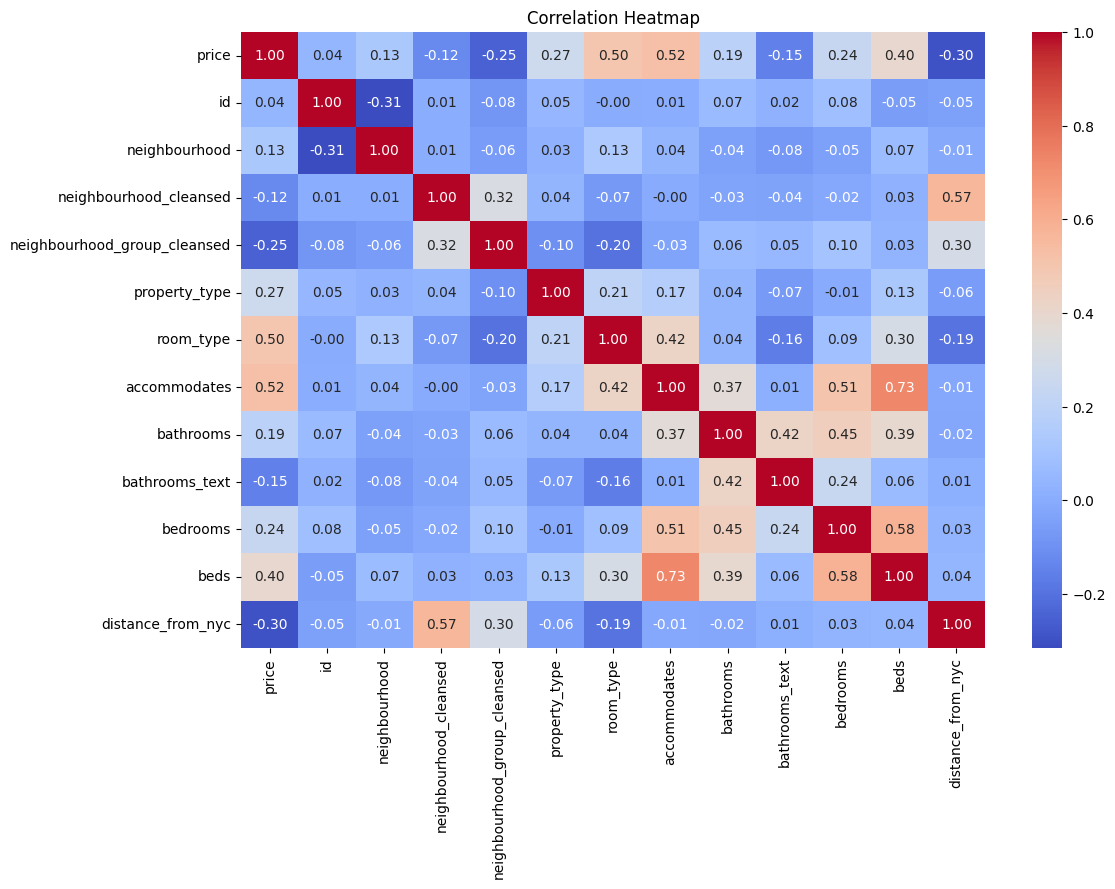

/var/folders/2l/zbm2jq117lx1kl87zx7prz1w0000gn/T/ipykernel_14985/1205777443.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location_bucket = location_bucket[data['bathrooms'] <= 10]


In [370]:
# Define the location-related columns (exclude 'amenities')
location_cols = [
    'price', 'id', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
    'latitude', 'longitude', 'property_type', 'room_type',
    'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds'
]

location_bucket = data[location_cols].copy()

# --- Compute distance from NYC center ---
# Define a function to calculate the haversine distance (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    return R * c

# NYC center coordinates (approximate)
nyc_center_lat = 40.7128
nyc_center_lon = -74.0060

# Compute distance for each row and store in a new column
location_bucket['distance_from_nyc'] = location_bucket.apply(
    lambda row: haversine(row['latitude'], row['longitude'], nyc_center_lat, nyc_center_lon),
    axis=1
)

# Drop the original latitude and longitude columns
location_bucket.drop(columns=['latitude', 'longitude'], inplace=True)

# --- Convert categorical columns into numeric codes ---
# Identify columns that are categorical (object dtype or that you know are categorical)
categorical_columns = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                       'property_type', 'room_type', 'bathrooms_text']

# Convert each categorical column to numeric codes using factorize
for col in categorical_columns:
    location_bucket[col], _ = pd.factorize(location_bucket[col])

# Ensure that all remaining columns are numeric (if any conversion is needed)
numeric_columns = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'distance_from_nyc']
location_bucket[numeric_columns] = location_bucket[numeric_columns].apply(pd.to_numeric, errors='coerce')

# fill na with mean
location_bucket.fillna(location_bucket.mean(), inplace=True)


# scatterplot vs price
for col in location_bucket.columns:
    if col != 'price':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='price', y=col, data=location_bucket)
        plt.title(f'Scatter Plot: Price vs {col}')
        plt.xlabel('Price')
        plt.ylabel(col)
        plt.show()

# correlation
corr_matrix = location_bucket.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# drop beds > 40
location_bucket = location_bucket[data['beds'] <= 40]
location_bucket = location_bucket[data['bathrooms'] <= 10]


location_bucket.drop(columns=['price'], inplace=True)

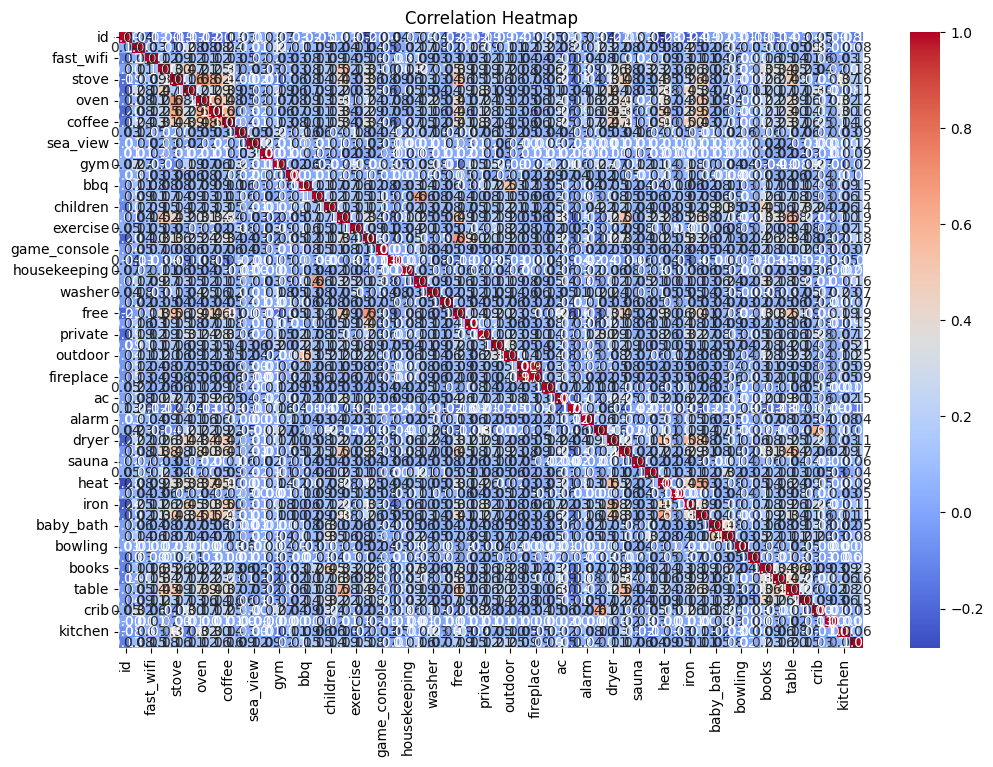

Dropped columns: ['ac', 'alarm', 'baby', 'baby_bath', 'bbq', 'bluetooth', 'books', 'bowling', 'breakfast', 'canal_view', 'children', 'clothing', 'ev_charger', 'exercise', 'fan', 'fast_wifi', 'fireplace', 'free', 'game_console', 'games', 'heat', 'hot_tub', 'hot_water', 'housekeeping', 'indoor', 'kitchen', 'outdoor', 'oven', 'parking', 'piano', 'pool', 'refrigerator', 'safe', 'sauna', 'sea_view', 'shared', 'ski', 'soap', 'stove', 'table', 'toaster', 'view', 'wifi']


id  shampoo  coffee  gym  sound_system  washer  paid  private  tv  \
0  39572        1       0    0             0       1     0        0   0   
1  39593        0       1    0             0       0     0        0   0   
3  42300        1       1    0             0       1     0        0   1   
4  42729        0       1    0             0       0     0        0   1   
5  43105        1       0    0             0       0     0        1   1   

   air_conditioning  chair  dryer  iron  crib  
0                 1      0      1     1     0  
1                 0      0      1     1     0  
3                 1      0      1     1     0  
4                 1      0      1     1     0  
5                 1      0      1     1     0

In [371]:
# amenities
amenities = data[['amenities', 'id', 'price']].copy()

keywords = [
    'fast wifi', 'soap', 'stove', 'shampoo', 'oven', 'refrigerator',
    'coffee', 'pool', 'sea view', 'canal view', 'gym', 'wifi', 'bbq', 'bluetooth', 'children',
    'clothing', 'exercise', 'parking', 'game console', 'hot tub', 'housekeeping', 'sound system',
    'washer', 'ev charger', 'free', 'paid', 'private', 'shared', 'outdoor', 'indoor', 'fireplace',
    'tv', 'ac', 'air conditioning', 'alarm', 'chair', 'dryer', 'toaster', 'sauna', 'safe', 'heat',
    'piano', 'iron', 'hot water', 'baby bath', 'baby', 'bowling', 'breakfast', 'books', 'fan',
    'table', 'games', 'crib', 'ski', 'kitchen', 'view'
]

# Create a column for each keyword
for keyword in keywords:
    col_name = keyword.replace(" ", "_")  # Ensure column names are valid
    amenities[col_name] = amenities['amenities'].str.contains(keyword, case=False, na=False).astype(int)

amenities.drop(columns=['amenities'], inplace=True)

# correlation
corr_matrix = amenities.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Compute the correlation matrix for numeric columns only
corr_matrix = amenities.corr()

# Get the absolute correlation values for 'price'
price_corr = corr_matrix['price'].abs()

# Identify columns (except 'price' itself) with absolute correlation less than 0.4
cols_to_drop = price_corr[price_corr < 0.15].index.difference(['price', 'id'])

# Drop those columns from the amenities DataFrame
amenities_reduced = amenities.drop(columns=cols_to_drop)

print("Dropped columns:", list(cols_to_drop))
amenities_reduced.drop(columns=['price'], inplace=True)
amenities_reduced.head()

In [372]:
dfs = [host_bucket, reviews_bucket, location_bucket, availability_bucket, amenities_reduced]
combined_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dfs)

# Check the merged DataFrame structure
print("Combined DataFrame shape:", combined_df.shape)
print(combined_df.head())

# Prepare data for linear regression
# Assume that the target is 'price'; drop columns that won't be used as predictors (like 'id' and 'price')
X = combined_df.drop(columns=['id', 'price'])
y = combined_df['price']

# Optionally, ensure X is numeric and there are no object columns:
print(X.dtypes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

Combined DataFrame shape: (22817, 36)
      id  host_location  host_acceptance_rate  host_neighbourhood  \
0  39593              1             60.000000                   1   
1  42300              1            100.000000                   2   
2  42729              1             33.000000                   3   
3  43105              2             67.000000                   4   
4  44229              1             77.814261                   5   

   host_listings_count  host_total_listings_count  \
0                  1.0                        1.0   
1                  1.0                        1.0   
2                  6.0                       12.0   
3                  2.0                        3.0   
4                  2.0                        5.0   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            1   
2                                            1   
3                           